In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)

In [2]:
set.seed(1)

In [3]:
invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150', 'TimeHeadway')
# invalids <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'flag', 'Curve100', 'Curve150')

In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
CV <- function(dfx, expr, verbose=FALSE) {        
    folds <- createFolds(dfx$flag)
    
    count <- 1
    errs <- c()
    reds <- c()
    blues <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        # fit <- rpart(expr, data=train, method="class")
        fit <- rpart(expr, data=train, method="class", cp=0.024)
        p <- predict(fit, newdata=test)
        predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]
        
        if (verbose) {            
            printf("Fold%d\n", count)
            result <- correctVsPredict(test, predictedFlags)
            reds <- c(reds, result[1])
            blues <- c(blues, result[2])
            count <- count + 1
            printf("\n")
        }
        
        nerr <- sum((predictedFlags == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(c(mean(errs), mean(reds), mean(blues)))
}

In [6]:
correctVsPredict <- function(test, predictedFlags) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    printf("As for Red: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
    printf("As for Blue: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)
    
    c(nCorrectReds/nPredictedReds, nCorrectBlues/nPredictedBlues)
}

In [7]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [8]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Red

In [9]:
df3 <- read.csv("../data/middle/sp4.csv", stringsAsFactors=FALSE)

In [10]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [11]:
allFeatures <- c(colnames(df3))
expr <- createFormula(invalids, allFeatures)

In [12]:
result <- CV(df3, expr, verbose=TRUE)
printRedRatios(df3)
printf("Red: Mean correct/predict = %f\n", result[2])
printf("Blue: Mean correct/predict = %f\n", result[3])
printf("CV value: %f", result[1])

Fold1
As for Red: correct/predict = 45/63 = 0.714286
As for Blue: correct/predict = 26/41 = 0.634146

Fold2
As for Red: correct/predict = 42/65 = 0.646154
As for Blue: correct/predict = 22/40 = 0.550000

Fold3
As for Red: correct/predict = 47/74 = 0.635135
As for Blue: correct/predict = 18/30 = 0.600000

Fold4
As for Red: correct/predict = 43/62 = 0.693548
As for Blue: correct/predict = 26/42 = 0.619048

Fold5
As for Red: correct/predict = 39/59 = 0.661017
As for Blue: correct/predict = 25/45 = 0.555556

Fold6
As for Red: correct/predict = 41/66 = 0.621212
As for Blue: correct/predict = 20/38 = 0.526316

Fold7
As for Red: correct/predict = 42/65 = 0.646154
As for Blue: correct/predict = 22/40 = 0.550000

Fold8
As for Red: correct/predict = 39/56 = 0.696429
As for Blue: correct/predict = 28/48 = 0.583333

Fold9
As for Red: correct/predict = 41/61 = 0.672131
As for Blue: correct/predict = 25/43 = 0.581395

Fold10
As for Red: correct/predict = 43/67 = 0.641791
As for Blue: correct/predict

In [13]:
fit3 <- rpart(expr, data=df3, method="class")

In [14]:
fit3$cptable[which.min(fit3$cptable[,"xerror"]),"CP"]

[1] 0.01781737

In [15]:
printcp(fit3)


Classification tree:
rpart(formula = expr, data = df3, method = "class")

Variables actually used in tree construction:
 [1] AccelerationSpeed AheadDistance     Curve             CurveAverage     
 [5] DistSignal        LaneCount         MaxSpeed          Pitch            
 [9] RiskFactor        RoadType          Speed            

Root node error: 449/1042 = 0.4309

n= 1042 

         CP nsplit rel error  xerror     xstd
1  0.064588      0   1.00000 1.00000 0.035602
2  0.051225      1   0.93541 1.02895 0.035715
3  0.042316      2   0.88419 0.97327 0.035476
4  0.031180      3   0.84187 0.87751 0.034862
5  0.017817      4   0.81069 0.84410 0.034586
6  0.015590      7   0.75724 0.87751 0.034862
7  0.014105      8   0.74165 0.89087 0.034964
8  0.011136     11   0.69933 0.89532 0.034996
9  0.010022     15   0.65479 0.90200 0.035044
10 0.010000     17   0.63474 0.89755 0.035012


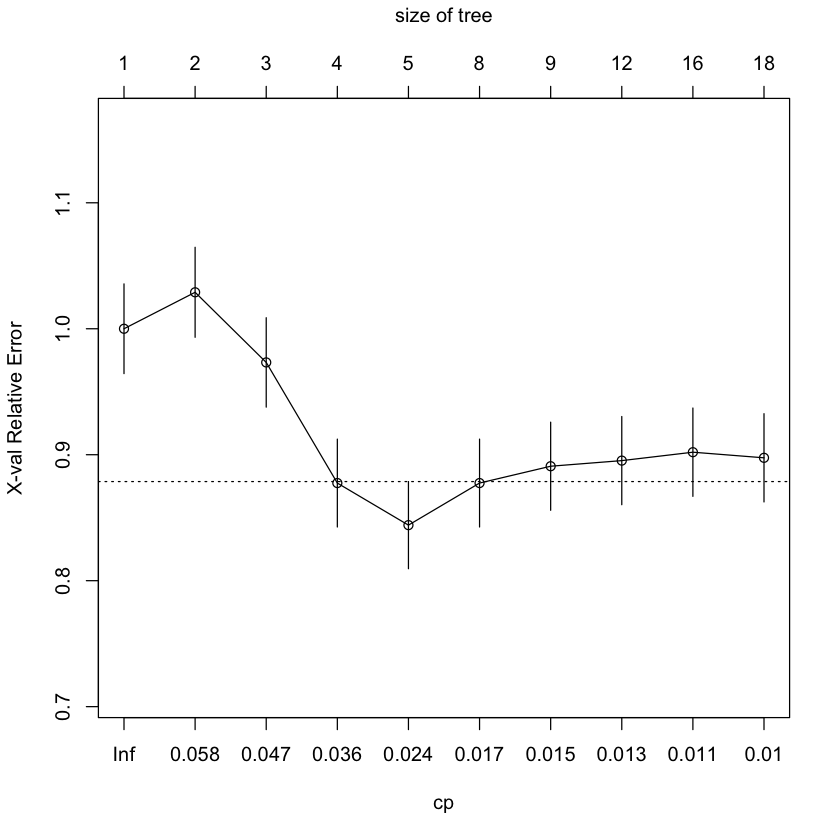

In [16]:
plotcp(fit3)

In [17]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

           CP nsplit rel error    xerror       xstd
1  0.06458797      0 1.0000000 1.0000000 0.03560167
2  0.05122494      1 0.9354120 1.0289532 0.03571534
3  0.04231626      2 0.8841871 0.9732739 0.03547629
4  0.03118040      3 0.8418708 0.8775056 0.03486225
5  0.01781737      4 0.8106904 0.8440980 0.03458567
6  0.01559020      7 0.7572383 0.8775056 0.03486225
7  0.01410542      8 0.7416481 0.8908686 0.03496369
8  0.01113586     11 0.6993318 0.8953229 0.03499635
9  0.01002227     15 0.6547884 0.9020045 0.03504427
10 0.01000000     17 0.6347439 0.8975501 0.03501247

Variable importance
         RoadType      CurveAverage             Speed          MaxSpeed 
               13                11                10                 9 
       RiskFactor             Curve        DistSignal             Pitch 
                8                 7                 6                 6 
    AheadDistance   AverageVelocity   TimeToC

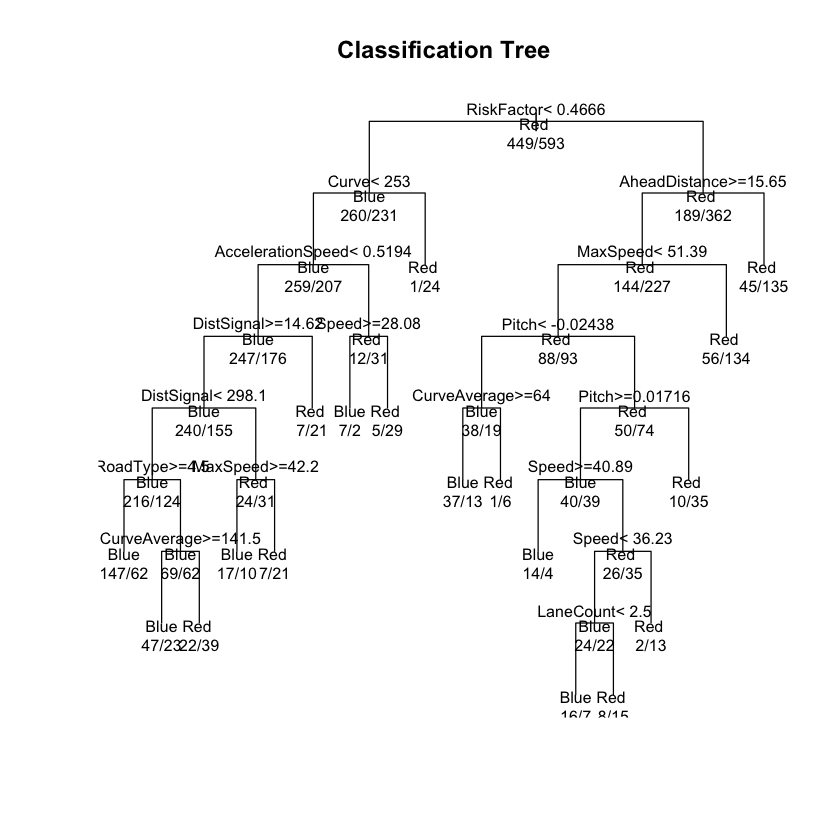

In [18]:
plot(fit3, uniform=TRUE, main="Classification Tree")
text(fit3, use.n=TRUE, all=TRUE, cex=.8)